In [1]:
import pandas as pd
import matplotlib.pylab as plt
from matplotlib.patches import Ellipse
import matplotlib.lines as lines
from matplotlib import cm
import numpy as np

from sqlalchemy import create_engine, event
import urllib.parse

# Input & Output

In [2]:
# SQL database
server = 'CSKMA0400\RDB_Data'
db = 'JLDJobPath'
odbc_connection_string = 'DRIVER={SQL Server Native Client 11.0};SERVER='+server+';DATABASE='+db+';Trusted_Connection=yes'

#Input Tables
flatjld_sql_table = "linkedclaims_casuals_2018m04_v2_flat_20140101"
clusters_sql_table = "linkedclaims_casuals_2018m04_v2_flat_multi_with_income_36Vars__7BGM_full_clusters"
fimportance_sql_table = "linkedclaims_casuals_2018m04_v2_flat_multi_with_income_36Vars__7BGM_full_clusters_FeatImportance"
cmeans_sql_table = "linkedclaims_casuals_2018m04_v2_flat_multi_with_income_36Vars__7BGM_full_clusters_means"
ccovars_sql_table = "linkedclaims_casuals_2018m04_v2_flat_multi_with_income_36Vars__7BGM_full_clusters_covars"

# Output
path="C:/Users/MarcoGrimaldi/AnacondaProjects/Analysis/MultiSampleFlatJLD/"
filename = '3-1 Cluster Profiling'+'.png'
png_file_output = path+filename

# Retrieve Data and plot cluster profiles

Read Data from SQL
Plotting Clusters


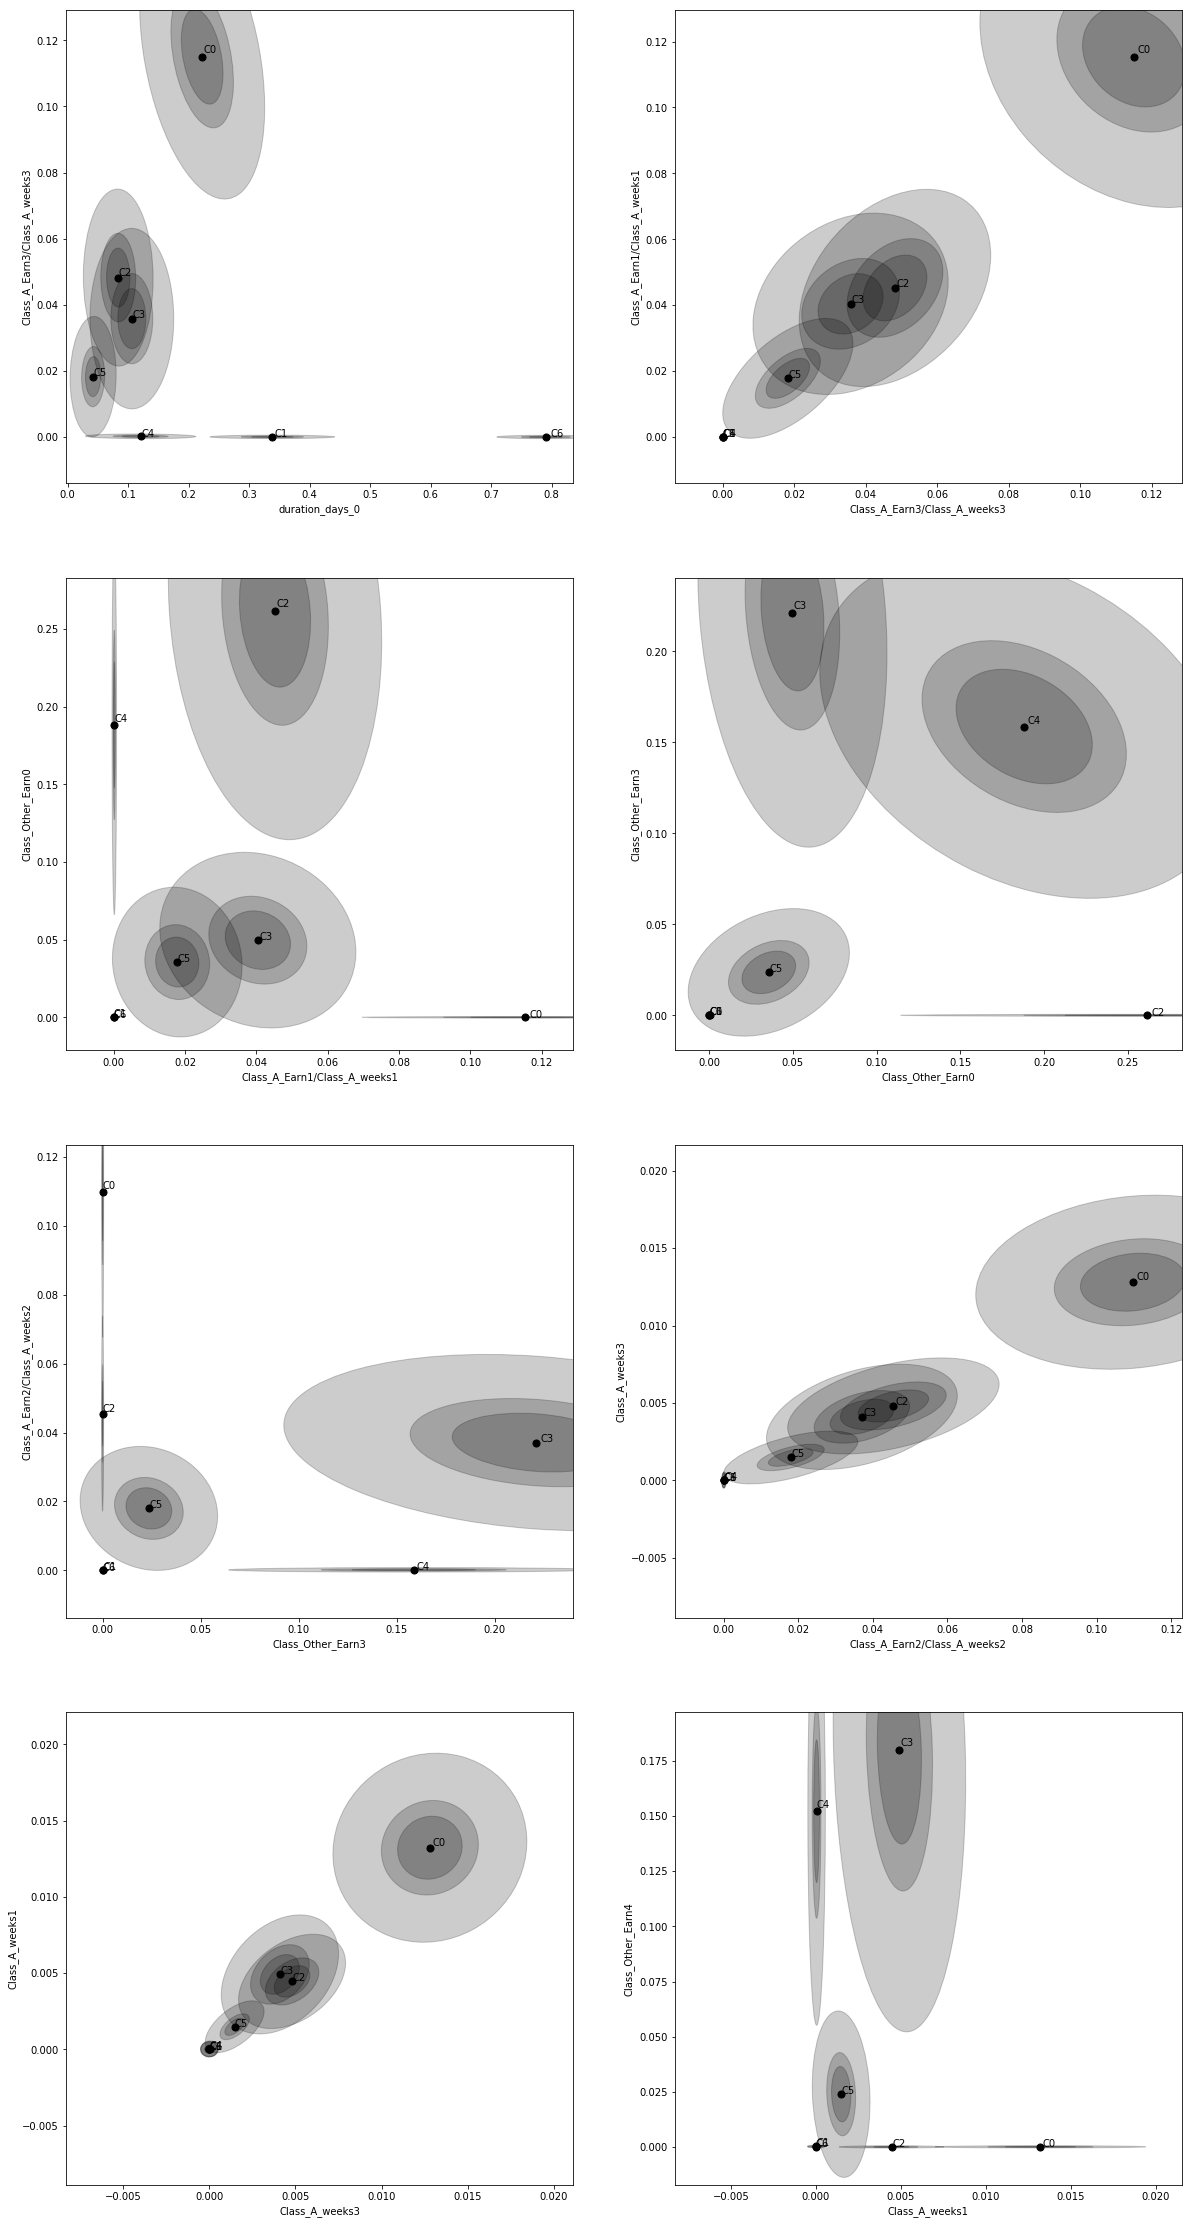

In [3]:
def plot_clusters(cmeans = None, ccovars = None, fimportance = None, ascendingimp = False, nplots=10, myfigsize = 20):

    if nplots is not None:
        if nplots > len(cmeans.columns.tolist()) -2:
            nplots = len(cmeans.columns.tolist()) -2
    else:
        nplots = len(cmeans.columns.tolist()) -2
    
    dim = (nplots,1)
    if nplots % 3 == 0:
        dim = (int(nplots/3), 3) 
    elif nplots % 2 == 0:
        dim = (int(nplots/2), 2)

    xsize = myfigsize
    ysize = myfigsize*dim[1]
    fig, axarr = plt.subplots(dim[0],dim[1],figsize=(xsize,ysize)) 
    
    variables_to_plot = [cmeans.columns.tolist()[i] for i in range(nplots+1)]
    variables_to_plot_indexes = [i for i in range(nplots+1)]
    if fimportance is not None:
        variables_to_plot = fimportance.sort_values(by='MeanImportance', ascending=ascendingimp)['FeatureName'].tolist()
        variables_to_plot = variables_to_plot[0:nplots+1]
        variables_to_plot_indexes = fimportance.sort_values(by='MeanImportance', ascending=ascendingimp).index.tolist()
        variables_to_plot_indexes = variables_to_plot_indexes[0:nplots+1]
    
    
    for row in range(dim[0]):
        for col in range(dim[1]):
                
            i = row * dim[1] + col
            
            my_axrr = axarr
            if dim[1] == 1 and dim[0] > 1:
                my_axrr = axarr[row]
            elif dim[0] == 1 and dim[1] > 1:
                my_axrr = axarr[col]
            elif dim[0] > 1 and dim[1] > 1:
                my_axrr = axarr[row,col]
            
            myx = variables_to_plot[i]
            myy = variables_to_plot[i+1]
            cmeans.plot(kind='scatter', x=myx, y=myy, \
                        ax=my_axrr, color=[0]*3, s = 50)
            
            for j, txt in enumerate(cmeans['cluster']):
                txt_x = cmeans[myx].iat[j] 
                txt_x = txt_x + txt_x * 1/100.0
                txt_y = cmeans[myy].iat[j] 
                txt_y = txt_y + txt_y * 1/100.0
                my_axrr.annotate('C' + str(txt), (txt_x, txt_y))
            
            if ccovars is not None:
                ccovars_dim = ccovars.shape
                cmeans_dim = cmeans.shape
                if ccovars_dim[0] == cmeans_dim[0] and ccovars_dim[1] == cmeans_dim[1]:
                    # This is the case for diagonal covariance matrix
                    for j in cmeans.index.tolist():
                        xy = (cmeans.iloc[j][myx], cmeans.iloc[j][myy])
                        width = ccovars.iloc[j][myx]
                        height = ccovars.iloc[j][myy]
                        ell = Ellipse(xy=xy, width=np.sqrt(width), height=np.sqrt(height))
                        my_axrr.add_artist(ell)
                        ell.set_clip_box(my_axrr.bbox)
                        ell.set_alpha(0.2)
                        ell.set_facecolor([0.2]*3)

                        mywidth = np.sqrt(width)/2
                        myheight = np.sqrt(height)/2
                        my_axrr.hlines(xy[1],xy[0]-mywidth,xy[0]+mywidth, color=[j/100.0]*3, linewidth=0.3)
                        my_axrr.vlines(xy[0],xy[1]-myheight,xy[1]+myheight, color=[j/100.0]*3, linewidth=0.3)
                
                elif ccovars_dim[0] == cmeans_dim[0]*(cmeans_dim[1]-1) and ccovars_dim[1] == cmeans_dim[1]:
                    # This is the case for full covariance matrix
                    for j in cmeans.index.tolist():
                        xy = (cmeans.iloc[j][myx], cmeans.iloc[j][myy])
                        covariances = ccovars.loc[ccovars.cluster == float(j), [myx, myy]]
                        covariances = covariances.iloc[[variables_to_plot_indexes[i], variables_to_plot_indexes[i+1]],:]
                        
                        v, w = np.linalg.eigh(covariances)
                        u = w[0] / np.linalg.norm(w[0])
                        angle = np.arctan2(u[1], u[0])
                        angle = 180 * angle / np.pi  # convert to degrees

                        for ne in range(1,4):
                            myv = np.sqrt(v)/float(ne)
                            ell = Ellipse(xy, myv[0], myv[1],\
                                            180 + angle, color=[0]*3)
                            ell.set_clip_box(my_axrr.bbox)
                            ell.set_alpha(0.2)
                            my_axrr.add_artist(ell)
                    
                
    return fig

# Connect to SQL
params = urllib.parse.quote_plus(odbc_connection_string)
engine = create_engine('mssql+pyodbc:///?odbc_connect=%s' % params)
conn = engine.connect().connection

@event.listens_for(engine, 'before_cursor_execute')
def receive_before_cursor_execute(conn, cursor, statement, params, context, executemany):
    if executemany:
        cursor.fast_executemany = True

print ("Read Data from SQL")
cmeans = pd.read_sql_table(cmeans_sql_table, engine)
ccovars = pd.read_sql_table(ccovars_sql_table, engine)
fimportance = pd.read_sql_table(fimportance_sql_table, engine)

conn.close()

print ("Plotting Clusters")
# %matplotlib wx
%matplotlib inline
myplot = plot_clusters (cmeans=cmeans, ccovars=ccovars, fimportance=fimportance, ascendingimp=False, nplots=8)

myplot.savefig(png_file_output)